## 📚 Importing Required Libraries

We start by importing the essential libraries for our workflow:
- File and directory handling (`os`)
- Image preprocessing and augmentation (`tensorflow.keras.preprocessing.image.ImageDataGenerator`)
- Building deep learning models with Keras (`Sequential`, convolutional layers, activation, dropout, etc.)
- Keras backend functions and activations (`backend`, `activations`)
- Model interpretability and visualization tools from `tf-keras-vis` (saliency maps, activation maximization)
- Plotting results using `matplotlib.pyplot`

In [16]:
# Importing required libraries

import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras.models import Model

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils import normalize

from matplotlib import pyplot as plt

## ⚙️ Global Configuration and Parameters

This section defines the global variables necessary for the training pipeline:

- **Paths** for the model, training, and validation datasets  
- **Model name** for saving and loading the trained model  
- **Image preprocessing and training parameters** such as image dimensions, batch size, number of epochs, and steps per epoch  
- **Control flags** like `multi_class` to specify classification mode  
- **Dataset sizes** for training and validation steps  


In [11]:
# Global variables
run_on_colab = True   # If you run on google colab or local

# Paths
path_model = "modele/"                            # Path where the model file will be saved
path_data = "data/dragonball/"                    # Path to the image dataset
train_data_dir = path_data + "train/"             # Path to training images
validation_data_dir = path_data + "validation/"   # Path to validation images
model_name = "dragonball_model"                   # Filename to save the trained model


# Image and training parameters
img_width = 150                  # Image width
img_height = 150                 # Image height
nb_train_samples = 43            # Number of training steps per epoch
nb_validation_samples = 43       # Number of validation steps per epoch
epochs = 50                      # Number of training epochs
batch_size = 16                  # Number of images per training batch
multi_class = True               # Set to True for multi-class classification

## 🧹 Cleaning Up Hidden Checkpoint Directories (Colab Only)

When working on Google Colab, hidden checkpoint directories `.ipynb_checkpoints` may be created inside dataset folders.  
This step removes those directories from the training and validation data folders to avoid potential issues during training.

The cleanup is performed by the function `remove_hidden_checkpoints_dirs(path)` which deletes the `.ipynb_checkpoints` folder if it exists.

**Note:** Run this cleanup only if you are working on Google Colab.


In [12]:
def remove_hidden_checkpoints_dirs(path):
    checkpoints_dir = os.path.join(path, '.ipynb_checkpoints')
    if os.path.isdir(checkpoints_dir):
        print(f"Remove {checkpoints_dir}")
        shutil.rmtree(checkpoints_dir)


if run_on_colab:
  remove_hidden_checkpoints_dirs(train_data_dir)
  remove_hidden_checkpoints_dirs(validation_data_dir)

Remove data/dragonball/train/.ipynb_checkpoints
Remove data/dragonball/validation/.ipynb_checkpoints


## 🏷️ Label Extraction and Data Generator Initialization

This section defines two utility functions:

- `extract_labels(train_dir)`  
  Retrieves and returns a sorted list of class labels based on the subfolders in the training directory.  
  Each subfolder is assumed to represent one class.

- `create_data_generators(train_dir, val_dir, img_size, batch_size)`  
  Initializes `ImageDataGenerator` instances for training and validation datasets.  
  The training generator applies data augmentation (shear, zoom, horizontal flip),  
  while the validation generator only rescales pixel values.


In [13]:
def extract_labels(train_dir):
    """
    Extracts a sorted list of class labels from the training directory.
    Each subdirectory inside 'train_dir' is considered as one class.

    Args:
        train_dir (str): Path to the training data directory.

    Returns:
        list[str]: Sorted list of class label names.
    """
    # List subdirectories and extract class names
    labels = [folder for folder in os.listdir(train_dir) if not folder.startswith('.')]
    labels = [label.replace(train_dir, "") for label in labels]
    labels = sorted(labels)
    return labels


def create_data_generators(train_dir, val_dir, img_size, batch_size):
    """
    Creates image data generators for training and validation.

    - Applies data augmentation to the training set.
    - Applies only rescaling to the validation set.

    Args:
        train_dir (str): Path to training data.
        val_dir (str): Path to validation data.
        img_size (tuple[int, int]): Image dimensions (width, height).
        batch_size (int): Number of images per batch.

    Returns:
        tuple: (train_generator, validation_generator)
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Only rescaling for validation
    val_datagen = ImageDataGenerator(rescale=1. / 255)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Validation generator
    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def get_input_shape(img_width, img_height):
    """
    Returns the correct input shape format depending on Keras backend configuration.

    Args:
        img_width (int): Image width.
        img_height (int): Image height.

    Returns:
        tuple[int]: Input shape.
    """
    if K.image_data_format() == 'channels_first':
        return (3, img_width, img_height)
    else:
        return (img_width, img_height, 3)


# --- Execution section ---

# 1. Extract and display class labels
label_list = extract_labels(train_data_dir)
print("Classes found:", len(label_list), label_list)

# 2. Create generators for training and validation datasets
train_generator, validation_generator = create_data_generators(
    train_data_dir,
    validation_data_dir,
    (img_width, img_height),
    batch_size
)

# 3. Determine the input shape for the model
input_shape = get_input_shape(img_width, img_height)


Classes found: 4 ['gohan', 'goku', 'piccolo', 'vegeta']
Found 140 images belonging to 4 classes.
Found 48 images belonging to 4 classes.


## 🔧 Building and Training the Convolutional Neural Network (CNN)

In this section, we define and train a simple Convolutional Neural Network (CNN) for image classification.

- The model is composed of three convolutional blocks: each includes a convolutional layer, a ReLU activation, and a max-pooling layer.
- A `Dropout` layer is added to reduce overfitting.
- The output layer and loss function are chosen based on the classification type:
  - **Multi-class classification**: softmax activation + categorical crossentropy loss
  - **Multi-label classification**: sigmoid activation + binary crossentropy loss
- The model is trained using `ImageDataGenerator` with data augmentation, as defined in the previous step.

After this step, the trained model is ready for evaluation or saving.


In [14]:
def build_model(input_shape, num_classes, multi_class=True):
    """
    Builds and compiles a CNN model for image classification.

    Args:
        input_shape (tuple[int]): Shape of input images.
        num_classes (int): Number of output classes.
        multi_class (bool): Whether the problem is multi-label (True) or multi-class (False).

    Returns:
        keras.models.Sequential: Compiled CNN model.
    """
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, name='conv1'))
    model.add(Activation('relu', name='relu1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))

    # Convolutional Block 2
    model.add(Conv2D(32, (3, 3), name='conv2'))
    model.add(Activation('relu', name='relu2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))

    # Convolutional Block 3
    model.add(Conv2D(64, (3, 3), name='conv3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))

    # Fully Connected Layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(64, name='dense1'))
    model.add(Activation('relu', name='relu4'))
    model.add(Dropout(0.5, name='dropout1'))
    model.add(Dense(num_classes, name='dense2'))

    # Output layer and loss function depending on classification type
    if multi_class:
        model.add(Activation('sigmoid', name='output'))
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
    else:
        model.add(Activation('softmax', name='output'))
        model.compile(
            loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy']
        )

    return model


def train_model(model, train_generator, validation_generator,
                steps_per_epoch, validation_steps, epochs):
    """
    Trains the CNN model using data generators.

    Args:
        model (keras.models.Sequential): Compiled CNN model.
        train_generator (DirectoryIterator): Generator for training data.
        validation_generator (DirectoryIterator): Generator for validation data.
        steps_per_epoch (int): Training steps per epoch.
        validation_steps (int): Validation steps per epoch.
        epochs (int): Number of epochs.

    Returns:
        keras.callbacks.History: Training history.
    """
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )
    return history


# --- Execution section ---

# 1. Build the CNN model
model = build_model(input_shape, num_classes=len(label_list), multi_class=multi_class)

# 2. Train the model and store training history
history = train_model(
    model,
    train_generator,
    validation_generator,
    steps_per_epoch=nb_train_samples,
    validation_steps=nb_validation_samples,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50
 9/43 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step - accuracy: 0.2571 - loss: 0.6950

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.2458 - loss: 0.6578 - val_accuracy: 0.3125 - val_loss: 0.5531
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.3740 - loss: 0.5707 - val_accuracy: 0.3125 - val_loss: 0.5315
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.3661 - loss: 0.5579 - val_accuracy: 0.4792 - val_loss: 0.4932
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4335 - loss: 0.5346 - val_accuracy: 0.4792 - val_loss: 0.4812
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5579 - loss: 0.4953 - val_accuracy: 0.7083 - val_loss: 0.4032
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.5806 - loss: 0.4600 - val_accuracy: 0.6458 - val_loss: 0.3875
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5711 - loss: 0.4368 - val_accuracy: 0.6458 - val_loss: 0.3667
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.6658 - loss: 0.3866 - val_accuracy: 0.7292 - v

#🔍 Visualizing Filter Activations in the Output Layer

To better understand what a Convolutional Neural Network (CNN) has learned, we visualize the internal representations captured by its filters. This step uses two complementary techniques:

### Saliency Maps  
These highlight which input pixels most strongly influence the activation of a specific filter in a given layer. They help interpret how the model reacts to real input images.

### Feature Maps (Intermediate Activations)  
These represent the actual outputs of a convolutional layer for a given input image. Visualizing them allows us to observe what each filter detects — such as edges, textures, or object parts — within the image. In our case, some filters appear to respond to human-like shapes, suggesting that the network has learned to focus on body structures relevant to our dataset.

---

### Process Overview

1. Identify the target convolutional layer.

2. For saliency maps, compute the gradient of the selected filter’s activation with respect to the input image to determine which parts of the input most affect that activation.

3. For feature maps, pass a real image through the model and extract the activations from the chosen layer.

4. Display the results:  
   - The saliency map shows where the model focuses its attention for a specific filter.  
   - The feature maps reveal what visual patterns or structures the filters have learned to detect in real inputs.


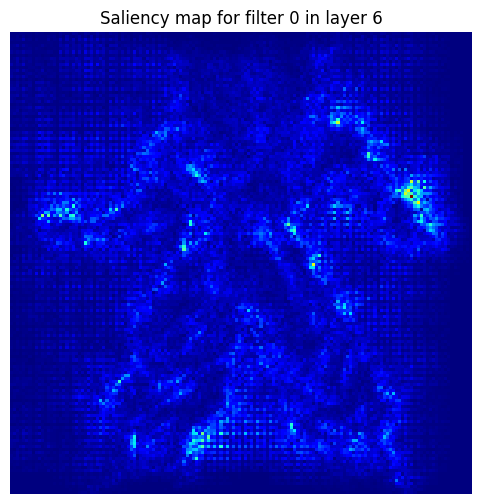

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


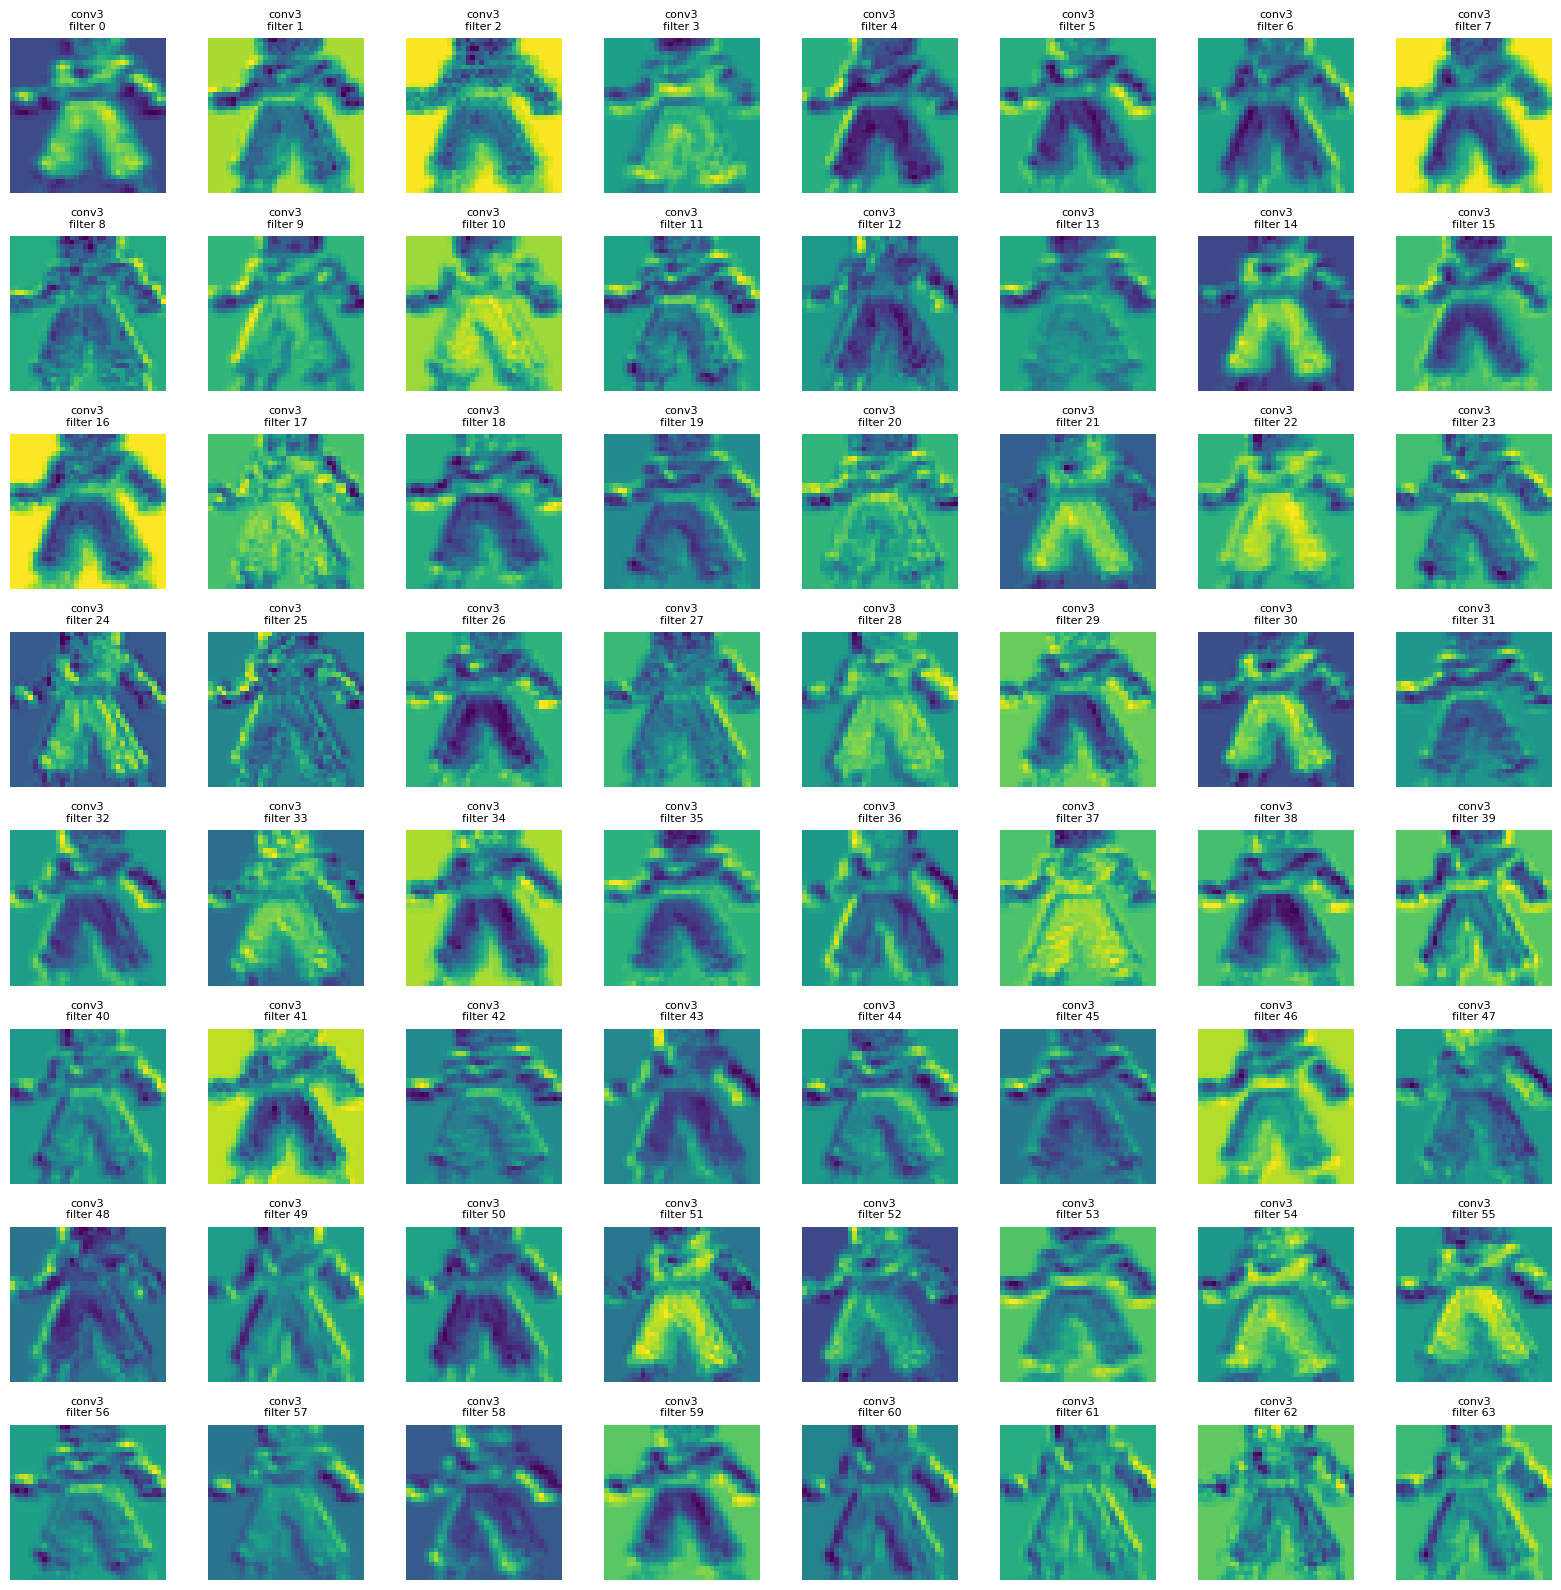

In [42]:
# Notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

def normalize(x):
    """
    Normalize a TensorFlow tensor to the range [0, 1].

    This function subtracts the minimum value from the tensor,
    then divides by the maximum value (plus a small epsilon to avoid division by zero).
    The resulting tensor is converted to a NumPy array before returning.

    Args:
        x (tf.Tensor): Input tensor to normalize.

    Returns:
        numpy.ndarray: Normalized array with values between 0 and 1.
    """
    x = x - tf.reduce_min(x)
    x = x / (tf.reduce_max(x) + 1e-8)
    return x.numpy()

def find_output_layer_index(model, layer_name="output"):
    """
    Return the index of a layer in the model by its name.

    Args:
        model (tf.keras.Model): The model containing the layers.
        layer_name (str, optional): The name of the layer to find. Defaults to "output".

    Returns:
        int: Index of the layer with the specified name.

    Raises:
        ValueError: If no layer with the specified name is found in the model.
    """
    for i, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return i
    raise ValueError(f"Layer {layer_name} not found in model")

def replace_activation_with_linear(model, layer_idx, multi_class=True):
    """
    Replace the activation function of a specified layer in the model with a linear activation,
    then recompile the model with appropriate loss and optimizer depending on the task type.

    Args:
        model (tf.keras.Model): The Keras model to modify.
        layer_idx (int): Index of the layer whose activation function will be replaced.
        multi_class (bool, optional): If True, use binary classification settings;
                                      if False, use multi-class classification settings.
                                      Defaults to True.

    Returns:
        tf.keras.Model: The modified and recompiled model.
    """
    model.layers[layer_idx].activation = activations.linear
    loss = 'binary_crossentropy' if multi_class else 'categorical_crossentropy'
    optimizer = 'rmsprop' if multi_class else 'adam'
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

def visualize_saliency_for_filter(model, layer_idx, filter_idx=0, seed_input=None):
    """
    Visualize the saliency map for a specific filter in a given layer of the model.

    This function computes the gradient-based saliency map that highlights
    which parts of the input most influence the activation of the specified filter.
    The model is modified to use a linear activation on the target layer to facilitate gradient computation.

    Args:
        model (tf.keras.Model): The model containing the target layer.
        layer_idx (int): Index of the layer containing the filter.
        filter_idx (int, optional): Index of the filter within the layer. Defaults to 0.
        seed_input (np.array or tf.Tensor, optional): Input image/tensor to compute saliency for.
                                                     If None, must be provided for visualization.

    Returns:
        None: Displays the saliency map using matplotlib.
    """
    saliency = Saliency(
        model,
        model_modifier=lambda m: replace_activation_with_linear(m, layer_idx),
        clone=True
    )
    def loss(output):
        return output[:, filter_idx]
    saliency_map = saliency(loss, seed_input=seed_input)
    saliency_map = normalize(saliency_map[0])
    plt.imshow(saliency_map, cmap='jet')
    plt.axis('off')
    plt.title(f'Saliency map for filter {filter_idx} in layer {layer_idx}')
    plt.show()

def visualize_feature_maps(model, layer_name, seed_input, n_cols=8):
    """
    Display the feature maps (activations) of a convolutional layer for a given input image.

    Args:
        model: Full Keras model.
        layer_name (str): Name of the Conv2D layer to inspect.
        seed_input: np.array, preprocessed image of shape (1, H, W, C).
        n_cols (int): Number of columns in the visualization grid.
    """
    # Create a sub-model that outputs the activations of the specified layer
    intermediate_model = Model(inputs=model.inputs,
                               outputs=model.get_layer(layer_name).output)

    # Perform a forward pass to get the feature maps
    feature_maps = intermediate_model.predict(seed_input)  # shape: (1, H, W, F)
    feature_maps = feature_maps[0]  # remove batch dimension

    n_features = feature_maps.shape[-1]  # total number of filters
    n_rows = int(np.ceil(n_features / n_cols))  # compute grid rows

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_features):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        fmap = feature_maps[..., i]  # extract filter i

        # Normalize the feature map for better visualization
        fmap -= fmap.min()
        fmap /= (fmap.max() + 1e-8)

        ax.imshow(fmap, cmap='viridis')
        ax.axis('off')
        ax.set_title(f"{layer_name}\nfilter {i}", fontsize=8)

    plt.tight_layout()
    plt.show()


# 1. Select the convolutional layer and filter index
conv_layer_idx = find_output_layer_index(model, "conv3")
filter_idx = 0

# 2. Compute and display the saliency map for a given input image
seed_input = next(train_generator)[0][0:1]
visualize_saliency_for_filter(model, conv_layer_idx, filter_idx, seed_input)

# 3. Visualize the feature maps (activations) of the selected convolutional layer
visualize_feature_maps(model, layer_name="conv3", seed_input=seed_input, n_cols=8)


## 💾 Saving the Neural Network Model

In this step, we save the trained neural network for future use:

- **Model architecture** is serialized to a JSON file. This stores the model structure without the weights.
- **Model weights** are saved separately in an HDF5 (`.h5`) file. These contain the learned parameters.
- The class labels are saved into a text file (`labels.txt` by default), one label per line, so that they can be referenced later during prediction or evaluation.


In [ ]:
def save_model_to_json(model, save_path, model_name):
    """
    Serialize and save the Keras model architecture to a JSON file.

    Args:
        model: Keras model instance
        save_path: str, directory path where the model JSON will be saved
        model_name: str, base filename for the saved model
    """
    model_json = model.to_json()
    json_filepath = os.path.join(save_path, model_name + ".json")
    with open(json_filepath, "w") as json_file:
        json_file.write(model_json)
    print(f"Model architecture saved to {json_filepath}")

def save_model_weights(model, save_path, model_name):
    """
    Serialize and save the Keras model weights to an HDF5 file.

    Args:
        model: Keras model instance
        save_path: str, directory path where the weights will be saved
        model_name: str, base filename for the saved weights
    """
    weights_filepath = os.path.join(save_path, model_name + ".weights.h5")
    model.save_weights(weights_filepath)
    print(f"Model weights saved to {weights_filepath}")

def save_labels(labels, save_dir, filename="labels.txt"):
    """
    Save the list of class labels into a text file, one label per line.

    Args:
        labels: list of str, class labels to save
        save_dir: str, directory where the file will be saved
        filename: str, name of the labels file (default "labels.txt")
    """
    labels_path = os.path.join(save_dir, filename)
    with open(labels_path, 'w') as f:
        for label in labels:
            f.write(f"{label}\n")
    print(f"Labels saved to {labels_path}")

def save_complete_model(model, save_path, model_name, labels):
    """
    Save the complete model (architecture and weights) and optionally class labels.

    Creates a dedicated folder named after the model inside save_path to organize files.

    Args:
        model: Keras model instance
        save_path: str, base directory where the model folder will be created
        model_name: str, base name for model files and folder
        labels: list of str or None, class labels to save in a text file
    """
    # Create directory named after the model
    model_dir = os.path.join(save_path, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # Save model architecture and weights (assuming these helper functions exist)
    save_model_to_json(model, model_dir, model_name)
    save_model_weights(model, model_dir, model_name)

    # Save labels
    save_labels(labels, model_dir)

    print(f"Model '{model_name}' and related files fully saved in directory '{model_dir}'")


# --- Execution section ---
save_complete_model(model, path_model, model_name, label_list)

Model architecture saved to modele/fairytail_model/fairytail_model.json
Model weights saved to modele/fairytail_model/fairytail_model.weights.h5
Labels saved to modele/fairytail_model/labels.txt
Model 'fairytail_model' and related files fully saved in directory 'modele/fairytail_model'


## 💾 Downloading the Model Files (Colab Only)

When working on Google Colab, you can use the following commands to download the saved model architecture (`.json`) his weights (`.h5`) and the classes labels (`.txt`) files directly to your local machine.

**Note:** This step is specific to Google Colab environments.


In [ ]:
if run_on_colab:
  from google.colab import files

  # Zip the model directory
  zip_path = f"{model_name}.zip"
  shutil.make_archive(model_name, 'zip', os.path.join(path_model,model_name))

  # Download the zip archive
  files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>